In [557]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [558]:
cars_data = pd.read_csv('car_details.csv')

In [559]:
cars_data.head()

,Marque,Modèle,Année,Type de carburant,Puissance fiscale,Kilométrage,Nombre de portes,Première main,État,Boîte à vitesses,Origine,Prix
0,Renault,Clio,2022,Essence,8 CV,35 000 - 39 999,5.0,Non,Très bon,Automatique,WW au Maroc,168 000 DH
1,Audi,A4,2014,Diesel,8 CV,170 000 - 179 999,5.0,NaN,Excellent,Manuelle,NaN,155 000 DH
2,Toyota,RAV 4,2014,Diesel,8 CV,200 000 - 249 999,5.0,Non,Excellent,Manuelle,WW au Maroc,146 000 DH
3,BMW,Série 5,2022,Electrique,10 CV,85 000 - 89 999,5.0,Oui,Excellent,Automatique,WW au Maroc,NaN
4,Peugeot,308,2021,Diesel,7 CV,70 000 - 74 999,5.0,Oui,Neuf,Manuelle,WW au Maroc,NaN


## Nettoyage : suppression de doublons, gestion des valeurs manquantes

<Axes: >

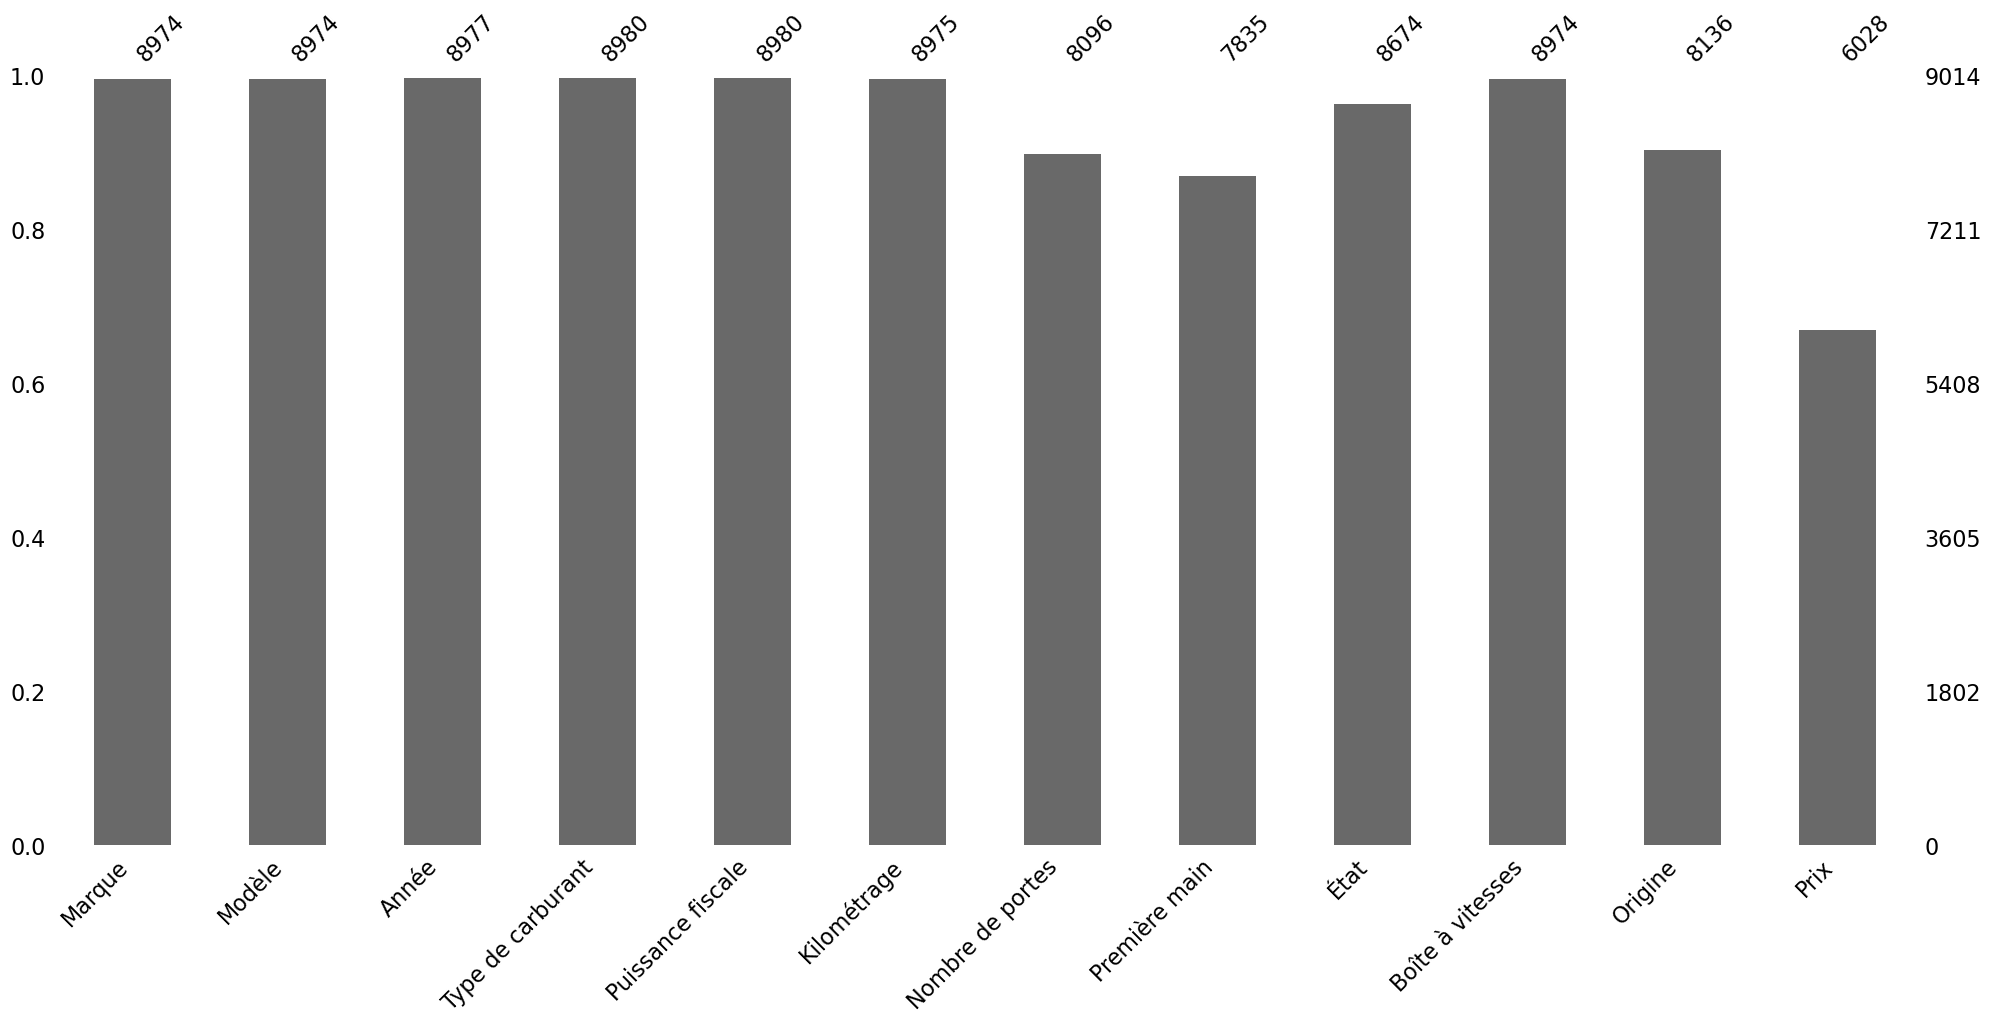

In [560]:
msno.bar(cars_data)

In [561]:
cars_data = cars_data.dropna(subset=['État','Origine','Prix'])

In [562]:
cars_data['Nombre de portes'] = cars_data['Nombre de portes'].fillna(cars_data['Nombre de portes'].mode()[0])

In [563]:
cars_data['Première main'] = cars_data['Première main'].fillna(cars_data['Première main'].mode()[0])

In [564]:
cars_data.isnull().sum().sum()

0

In [565]:
cars_data['Prix'] = cars_data['Prix'].str.replace(r'[^\d]','',regex=True)
cars_data['Prix'] = pd.to_numeric(cars_data['Prix'],errors='coerce')

In [566]:
cars_data['Puissance fiscale'] = cars_data['Puissance fiscale'].str.replace(' CV','',regex=False)
cars_data['Puissance fiscale'] = pd.to_numeric(cars_data['Puissance fiscale'],errors='coerce')

In [567]:
cars_data['Kilométrage'] = cars_data['Kilométrage'].str.replace('Plus de ','',regex=False)

In [568]:
cars_data['Année'] = cars_data['Année'].str.replace(' ou plus ancien','',regex=False)
cars_data['Année'] = pd.to_numeric(cars_data['Année'])

In [569]:
cars_data['Nombre de portes'] = cars_data['Nombre de portes'].astype(int)

In [570]:
def calculate_average_km(kms):
    parts = kms.split('-')
    nums = [float(p.strip().replace(' ', '')) for p in parts]
    return sum(nums) / len(nums)
cars_data['average_km'] = cars_data['Kilométrage'].apply(calculate_average_km)
cars_data = cars_data.drop(columns=['Kilométrage'])

In [571]:
cars_data.head()

,Marque,Modèle,Année,Type de carburant,Puissance fiscale,Nombre de portes,Première main,État,Boîte à vitesses,Origine,Prix,average_km
0,Renault,Clio,2022,Essence,8.0,5,Non,Très bon,Automatique,WW au Maroc,168000,37499.5
2,Toyota,RAV 4,2014,Diesel,8.0,5,Non,Excellent,Manuelle,WW au Maroc,146000,224999.5
5,Peugeot,308,2018,Diesel,6.0,5,Non,Excellent,Manuelle,WW au Maroc,169000,32499.5
6,Seat,Toledo,2013,Diesel,6.0,5,Non,Excellent,Manuelle,WW au Maroc,120000,224999.5
7,Mini,CountryMan,2012,Essence,8.0,5,Non,Neuf,Manuelle,WW au Maroc,103000,124999.5


In [572]:
print(len(cars_data))
cars_data = cars_data.drop_duplicates()
print(len(cars_data))

5337
5172


## Feature enginnering

In [573]:
cars_data["Âge"] = 2025 - cars_data["Année"]
cars_data = cars_data.drop(columns=['Année'])

## Outliers

In [574]:
def remove_outliers_iqr(cars_data, column, multiplier=1.5):
    q1 = cars_data[column].quantile(0.25)
    q3 = cars_data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - multiplier * iqr
    upper = q3 + multiplier * iqr
    return cars_data[(cars_data[column] >= lower) & (cars_data[column] <= upper)]

In [575]:
def remove_rare_values(cars_data, column, min_count=3):
    value_counts = cars_data[column].value_counts()
    valid_values = value_counts[value_counts >= min_count].index
    return cars_data[cars_data[column].isin(valid_values)]

In [576]:
def clean_numeric_columns(cars_data):
    cars_data = remove_outliers_iqr(cars_data, 'Prix')
    cars_data = cars_data[cars_data['average_km'] <= 400000]
    cars_data = cars_data[cars_data['Âge'] <= 30]
    cars_data = remove_rare_values(cars_data, 'Puissance fiscale', min_count=3)
    return cars_data

In [593]:
cars_data = clean_numeric_columns(cars_data)
cars_data.to_csv('cars_data_cleaned.csv',index=False)

In [578]:
num_cols = ['Année', 'Puissance fiscale', 'Nombre de portes', 'Prix', 'average_km']

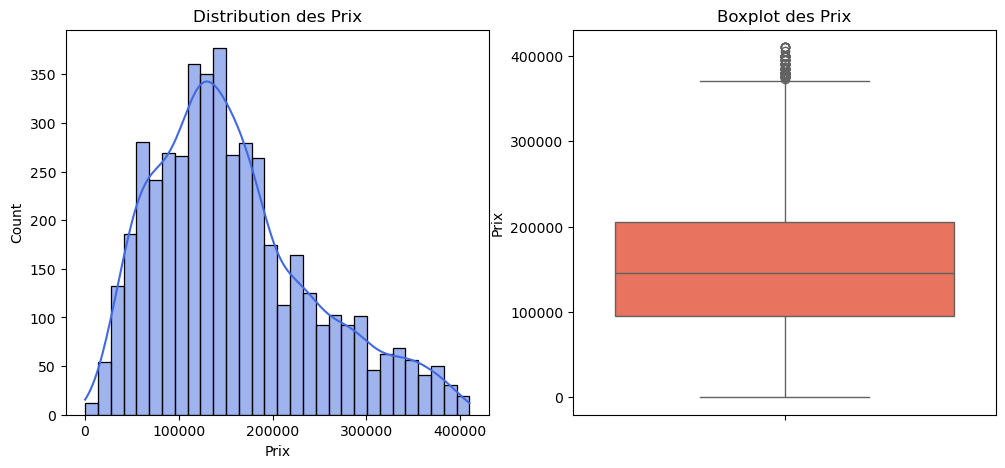

In [579]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(cars_data['Prix'], kde=True, bins=30, color='royalblue')
plt.title('Distribution des Prix')

plt.subplot(1, 2, 2)
sns.boxplot(y=cars_data['Prix'], color='tomato')
plt.title('Boxplot des Prix')
plt.show()

## Data Split

In [580]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [581]:
X = cars_data.drop(columns=['Prix'])
y = cars_data['Prix']

In [582]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (3740, 11)
Test set: (936, 11)


## Encodage des variables catégoriques

In [583]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

In [584]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat_cols = ['Marque', 'Modèle', 'Première main']
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [585]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = ['Puissance fiscale', 'average_km', 'Âge']

In [586]:
OneHotEncoder = OneHotEncoder(sparse_output=False)
X_train_encoded = OneHotEncoder.fit_transform(X_train[cat_cols])   
X_test_encoded = OneHotEncoder.transform(X_test[cat_cols])

In [587]:
RobustScaler = RobustScaler()
X_train_scaled = RobustScaler.fit_transform(X_train[num_cols])
X_test_scaled = RobustScaler.transform(X_test[num_cols])

In [588]:
X_train = pd.concat([
    pd.DataFrame(X_train_encoded, columns=OneHotEncoder.get_feature_names_out(cat_cols)),
    pd.DataFrame(X_train_scaled, columns=num_cols),
    X_train.drop(columns=cat_cols + num_cols).reset_index(drop=True)
], axis=1)

X_test = pd.concat([
    pd.DataFrame(X_test_encoded, columns=OneHotEncoder.get_feature_names_out(cat_cols)),
    pd.DataFrame(X_test_scaled, columns=num_cols),
    X_test.drop(columns=cat_cols + num_cols).reset_index(drop=True)
], axis=1)

In [589]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=15,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 15 folds for each of 27 candidates, totalling 405 fits


GridSearchCV(cv=15,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [590]:
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur MAE (validation): {-grid_search.best_score_:.2f} dh")

Meilleurs paramètres: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Meilleur MAE (validation): 18978.13 dh


In [591]:
y_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE sur le test set: {mae_test:.2f} dh")

MAE sur le test set: 20859.54 dh
